In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

from sklearn.decomposition import NMF

In [2]:
# Load the configuration file
with open("workspace/config.yml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

lame = config['lame']
path = f"{config['path_to_data']}/{lame}"

In [3]:
# load the data
peaks = pd.read_csv(f"{path}/results/mse_spectra_region.csv")
pixels = pd.read_csv(f"{path}/results/mse_pixels_region.csv")

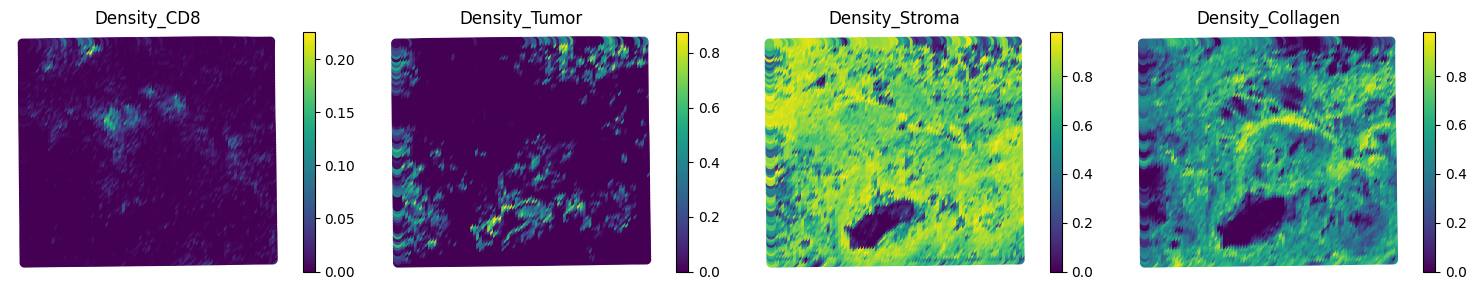

In [4]:
# plot the pixels data
fig, axs = plt.subplots(1, 4, figsize=(15, 3), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, density in zip(axs.flatten(), [col for col in pixels.columns if 'Density' in col][:-2]):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels[density], cmap='viridis')
    ax.set_title(density)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

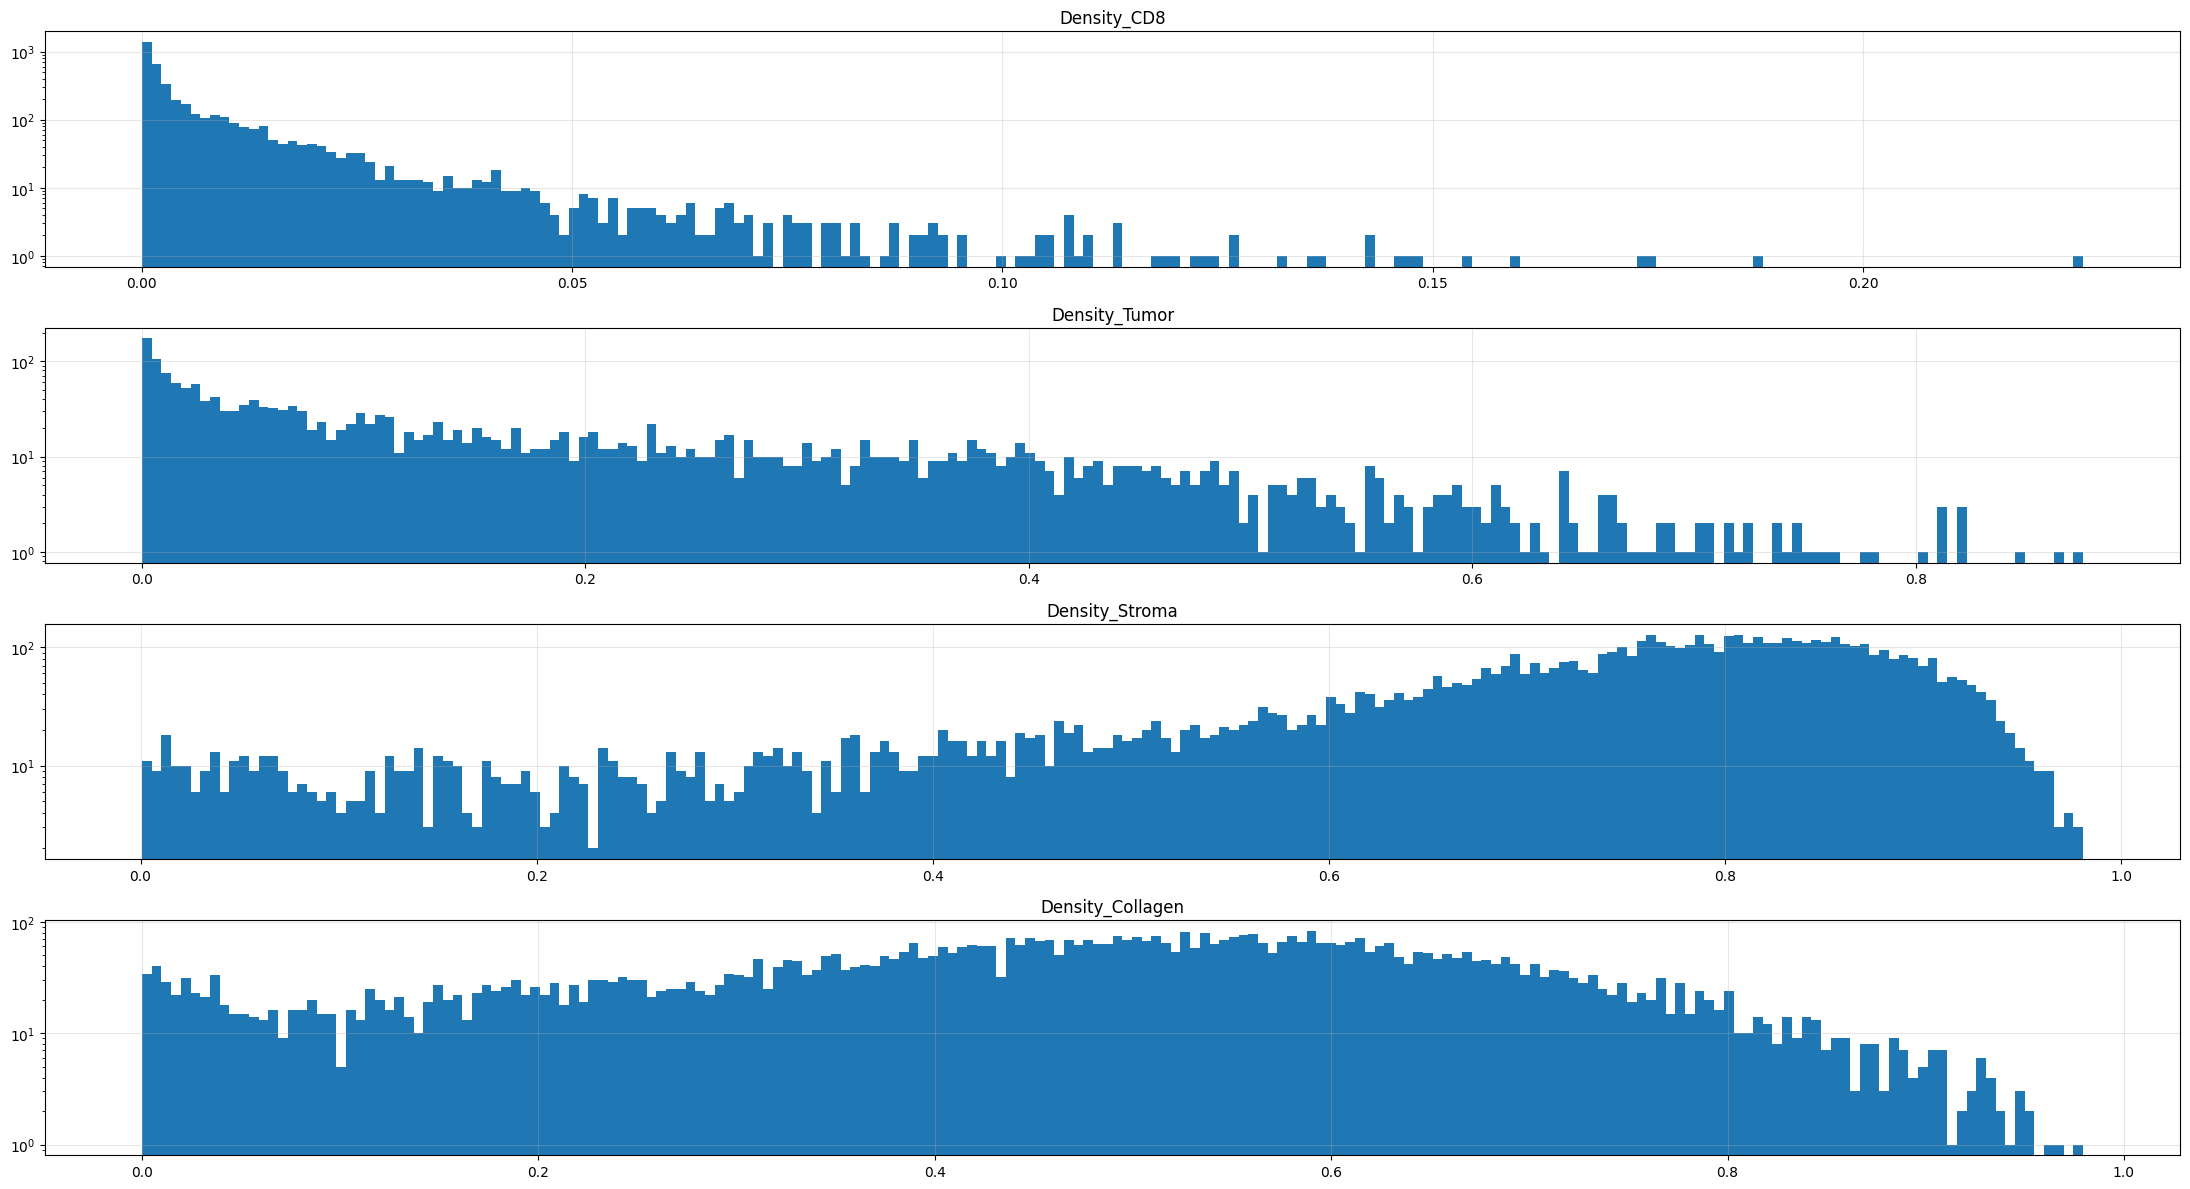

In [5]:
# Make a histogram of the pixel densities data
fig, axs = plt.subplots(4, 1, figsize=(22, 12), tight_layout=True)

for ax, density in zip(axs.flatten(), [col for col in pixels.columns if 'Density' in col][:-2]):
    ax.hist(pixels[density][pixels[density] != 0], bins=200)
    ax.set_title(density)
    ax.set_yscale('log')
    ax.grid(alpha=0.3)

plt.show()

In [6]:
# produce thresholded images
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

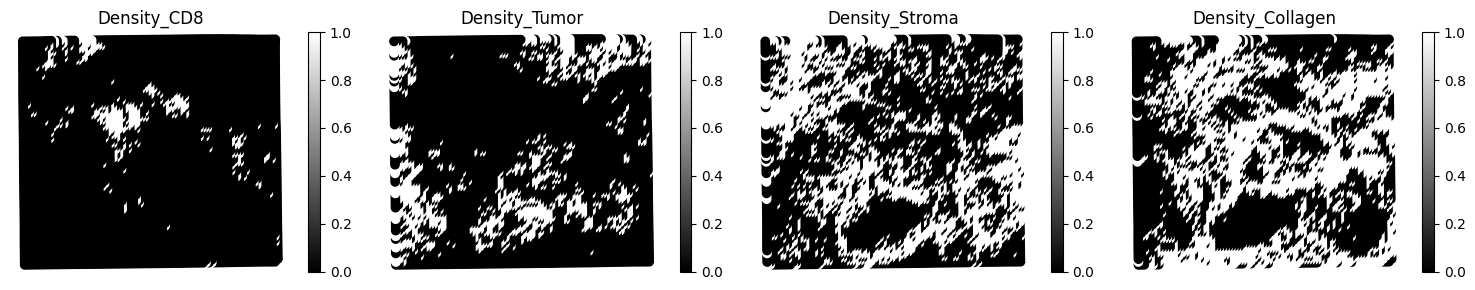

In [7]:
# plot the pixels densities with threshold
fig, axs = plt.subplots(1, 4, figsize=(15, 3), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, density in zip(axs.flatten(), [col for col in pixels.columns if 'Density' in col][:-2]):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels[density] > threshold[density], cmap='gray')
    ax.set_title(density)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

In [8]:
# Perform NMF on the peaks data
model = NMF(n_components=32,
            init='nndsvd',
            solver='cd',
            max_iter=10**6,
            random_state=42)

w = model.fit_transform(peaks.iloc[:, 1:])
h = model.components_

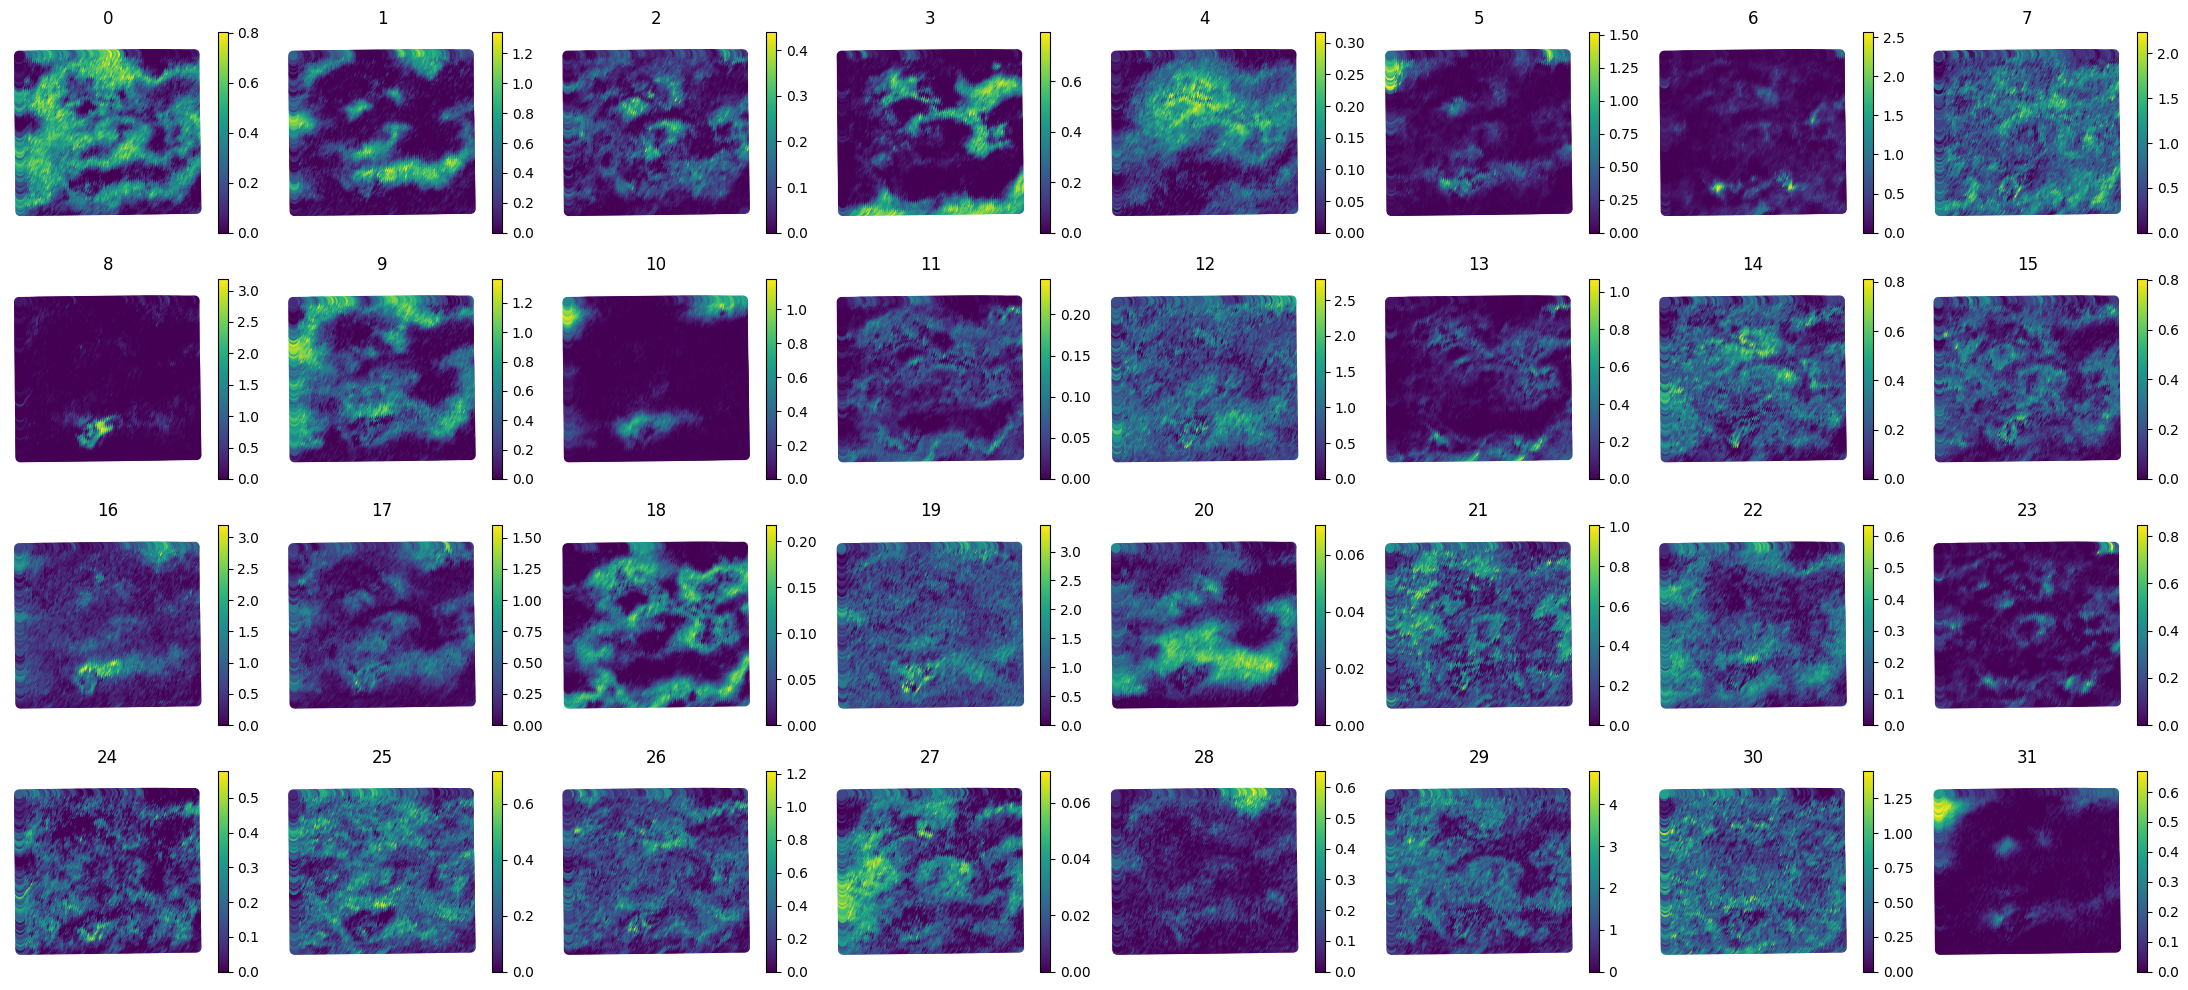

In [14]:
# Put the factors in a DataFrame
factors = pd.DataFrame(w, columns=[i for i in range(w.shape[1])])

# plot the factors
fig, axs = plt.subplots(4, 8, figsize=(22, 10), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, factor in zip(axs.flatten(), factors.columns):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=factors[factor], cmap='viridis')
    ax.set_title(factor)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

In [10]:
# Spearman correlation
correlations_spearman = {}
for density in [col for col in pixels.columns if 'Density' in col][:-2]:
    correlations_spearman[density] = [factors[factor].corr(pixels[density], method='spearman')
                                      for factor in factors.columns]
    
# Pearson correlation
correlations_pearson = {}
for density in [col for col in pixels.columns if 'Density' in col][:-2]:
    correlations_pearson[density] = [factors[factor].corr(pixels[density], method='pearson')
                                      for factor in factors.columns]
    
# Compute the log2fold change of the factors between the thresholded images
log2fold_change = {}
for density in [col for col in pixels.columns if 'Density' in col][:-2]:
    log2fold_change[density] = [np.log2(factors[factor][pixels[density] > threshold[density]].mean() /
                                  factors[factor][pixels[density] <= threshold[density]].mean())
                               for factor in factors.columns]

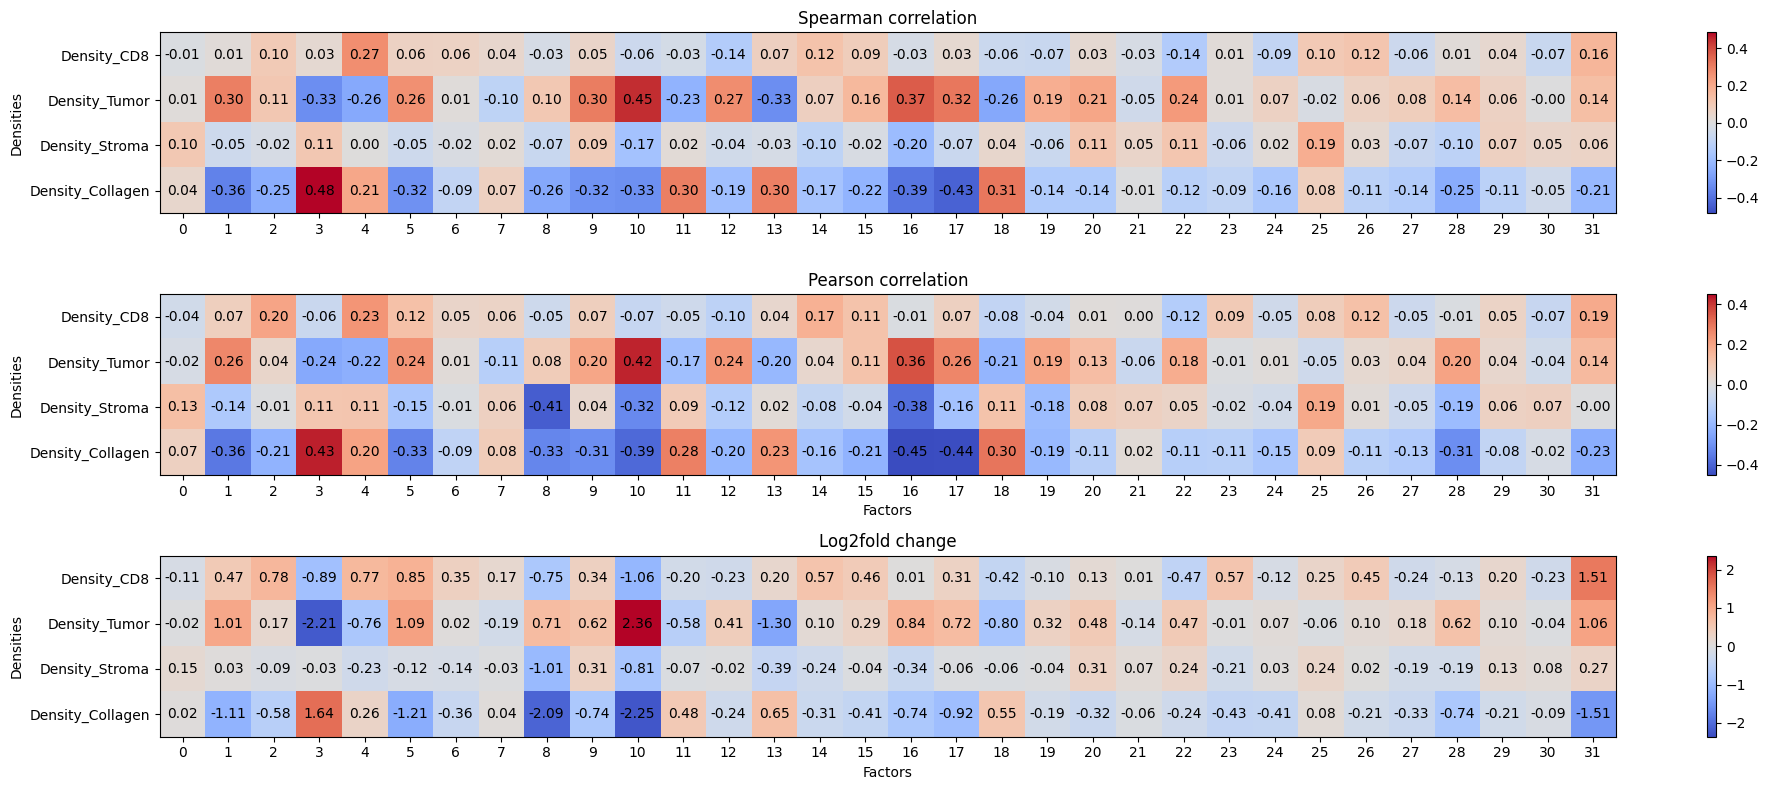

In [11]:
# Create dataframes
df_spearman = pd.DataFrame(correlations_spearman, index=factors.columns)
df_spearman_abs_max = df_spearman.abs().max().max()

df_pearson = pd.DataFrame(correlations_pearson, index=factors.columns)
df_pearson_abs_max = df_pearson.abs().max().max()

df_log2fold_change = pd.DataFrame(log2fold_change, index=factors.columns)
log2fold_abs_max = np.abs(df_log2fold_change).max().max()

# Plot the correlations
fig, axs = plt.subplots(3, 1, figsize=(20, 8), tight_layout=True)

axs[0].imshow(df_spearman.T, cmap='coolwarm', aspect='auto')
# add annotations
for i in range(df_spearman.shape[0]):
    for j in range(df_spearman.shape[1]):
        axs[0].text(i, j, f"{df_spearman.T.iloc[j, i]:.2f}", ha='center', va='center', color='black')
axs[0].set_title('Spearman correlation')
axs[0].set_ylabel('Densities')
axs[0].set_xticks(range(df_spearman.shape[0]))
axs[0].set_yticks(range(df_spearman.shape[1]))
axs[0].set_yticklabels(df_spearman.columns)
cbar = fig.colorbar(axs[0].imshow(df_spearman.T, cmap='coolwarm', aspect='auto', vmin=-df_spearman_abs_max, vmax=df_spearman_abs_max))

axs[1].imshow(df_pearson.T, cmap='coolwarm', aspect='auto')
# add annotations
for i in range(df_pearson.shape[0]):
    for j in range(df_pearson.shape[1]):
        axs[1].text(i, j, f"{df_pearson.T.iloc[j, i]:.2f}", ha='center', va='center', color='black')
axs[1].set_title('Pearson correlation')
axs[1].set_ylabel('Densities')
axs[1].set_xlabel('Factors')
axs[1].set_xticks(range(df_pearson.shape[0]))
axs[1].set_yticks(range(df_pearson.shape[1]))
axs[1].set_yticklabels(df_pearson.columns)
cbar = fig.colorbar(axs[1].imshow(df_pearson.T, cmap='coolwarm', aspect='auto', vmin=-df_pearson_abs_max, vmax=df_pearson_abs_max))

axs[2].imshow(df_log2fold_change.T, cmap='coolwarm', aspect='auto')
# add annotations
for i in range(df_log2fold_change.shape[0]):
    for j in range(df_log2fold_change.shape[1]):
        axs[2].text(i, j, f"{df_log2fold_change.T.iloc[j, i]:.2f}", ha='center', va='center', color='black')
axs[2].set_title('Log2fold change')
axs[2].set_ylabel('Densities')
axs[2].set_xlabel('Factors')
axs[2].set_xticks(range(df_log2fold_change.shape[0]))
axs[2].set_yticks(range(df_log2fold_change.shape[1]))
axs[2].set_yticklabels(df_log2fold_change.columns)
cbar = fig.colorbar(axs[2].imshow(df_log2fold_change.T, cmap='coolwarm', aspect='auto', vmin=-log2fold_abs_max, vmax=log2fold_abs_max))

plt.show()